# DERIVING TRANSFER FUNCTIONS

This notebook demonstrates how transfer functions can be derived directly from a chemical model.

What we present is *not* a general technique. It only works if the underlying network can be represented by a system of linear differential equations. In practice this means that: (a) all reactions have a single reactant and (b) the kinetics are masss action.

We use the following notation:
* $s$: Laplace transform variable
* $G(s)$: Transfer function
* $S_n$: $n$-th chemical species
* $S_n (t)$ time course value of $S_n$ at time $t$. If the context permits (e.g., a rate law), $S_n (t)$ is denoted by just $S_n$.
* $\dot{S}_n (t)$: First derivative of $S_n(t)$
* $S_n(s)$: Laplace Transform of the concentration of $S_n$

Reactions are described by arrows. For example, $S_1$ is converted to $S_2$ at a rate $k_1 S_1$  is denoted by $S_1 \xrightarrow{k_1 S_1} S_2$.

# Preliminaries

In [17]:
!pip install -q control
!pip install -q tellurium
import numpy as np
import control
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [47]:
k1=1; k2=2; k3=3;
TEST_MODEL = f"""
$S1 -> S2; k1*S1
S2 -> 3 S2 + S3; k2*S2
S3 -> ; k3*S3

S1 = 1
S2 = 0
S3 = 0
k1 = {k1}
k2 = {k2}
k3 = {k3}
"""
# Construct the transfer function for G(s) at k1=1
TEST_TF = control.TransferFunction([k2*k1], [1, k3 - 2*k2, -2*k2*k3])
#

In [ ]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax

    def __repr__(self):
        return ""

## plotTransferFunction

In [44]:
def plotTransferFunction(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTransferFunction(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


## evaluateTransferFunction

In [51]:
def evaluateTransferFunction(antimony_model:str, transfer_function:control.TransferFunction,
        is_plot:bool=True):
    # Plot the simulation results against the transfer function predictions
    # Assumes that the forced input is 1 and that the output is the last species in the simulation model
    rr = te.loada(antimony_model)
    data = rr.simulate(0, 10, 100)
    output_name = data.colnames[-1]
    times = data["time"]
    _, yt = control.step_response(G_tf, T=times)
    ymax = np.max(data[output_name])
    plt.scatter(data[output_name], yt)
    plt.plot([0, ymax], [0, ymax], color="red", linestyle="--")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title(output_name[1:-1])
    if not is_plot:
        plt.close()
        
# TESTS
evaluateTransferFunction(TEST_MODEL, TEST_TF, is_plot=False)
print("OK!")

OK!


# Model 1: 1 Stage Sequential Reaction Network

Consider the one step sequential pathway with mass action kinetics
$S_1 \xrightarrow{k_1 S_1} S_2$, $S_2 \xrightarrow{k_2 S_2} \emptyset$

The system we consider has input $S_1$, and its output is $S_2$.
We want the transfer function $G(s) = \frac{S_2(s)}{S_1(s)}$.

## 1. System equations

\begin{eqnarray}
S_1  & \xrightarrow{k_1 S_1 } & S_2 \\
S_2 & \xrightarrow{k_2 S_2} & \emptyset
\end{eqnarray}

We do not analyze $\dot{S}_1$ since it is treated as a boundary species (a forced input), and
hence $\dot{S}_1 = 0$.
* $\dot{S}_2 = k_1 S_1 - k_2 S_2$

## 2. LT of system equations

Going from the state equations to Laplace Transforms is very mechanical. Replace $\dot{x}$ with $s X(s)$, and replace $x$ with $X(s)$.

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2(s) \\
\end{eqnarray}

## 3. Solve for transfer function

$G(s) = \frac{S_2 (s)}{S_1 (s)} = \frac{k_1}{s + k_2}$

**Questions**
* What are the poles of $G(s)$?
* What is the DC gain of $G(s)$?

## 4. Predict step response from TF

### 4a. Construct transfer function

The function ``control.TransferFunction`` provides a way to construct transfer functions and calculate with them.

A transfer function represented by a numerator polynomial in $s$ and a denominator polynomial in $s$.
A polynomial in $s$ is a list of floats.
The last element of the list is the coefficient for $s^0$;
element last - 1 is the coefficient for $s^1$; and so on.

For example, [1, 2, 3] represents the polynomial $s^2 + 2 s + 3$.

In [ ]:
# Describing a polynomial in s
# The list [1, 2, 3] species a polynomial that is s**2 + 2*s + 3

In [ ]:
# Write the transfer function for 1/(s**2 + 5)
control.TransferFunction([1], [1, 0, 5])

TransferFunction(array([1]), array([1, 0, 5]))

In [20]:
# Construct the transfer function for G(s) at k1=1, k2=2
k1 = 1
k2 = 2
G_tf = control.TransferFunction([k1], [1, k2])
G_tf

TransferFunction(array([1]), array([1, 2]))

In [21]:
# The controls package calculates poles of transfer functions
G_tf.poles()

array([-2.+0.j])

In [22]:
# The controls package also calculates DC Gain
G_tf.dcgain()

0.5

### 4b. Predict step response

Text(0.5, 0, 'time')

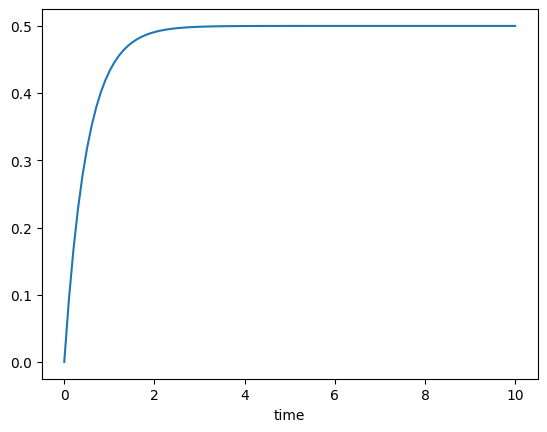

In [23]:
# Use control.forced_response
times = np.linspace(0, 10, 100)
_, yt = control.step_response(G_tf, T=times)
plt.plot(times, yt)
plt.xlabel("time")

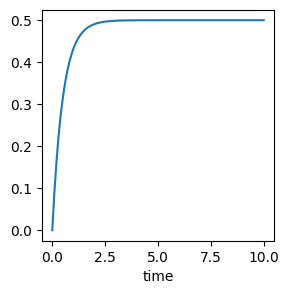

In [24]:
# We can wrap the foregoing into a function
plotTransferFunction(G_tf, figsize=(3,3))

## 5. Simulate the Antimony model

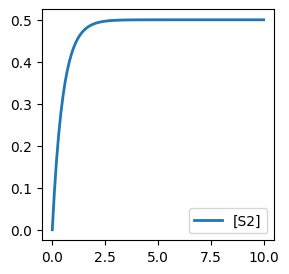

In [26]:
SEQUENTIAL_MODEL = """
$S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 1
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

### More accurate and scalable way to compare models

Want to know if the simulated (actual) values and predicted (from transfer function) are the same at each time step. This means that one they are plotted, each point lines on the line of unit slope.

Text(0, 0.5, 'predicted')

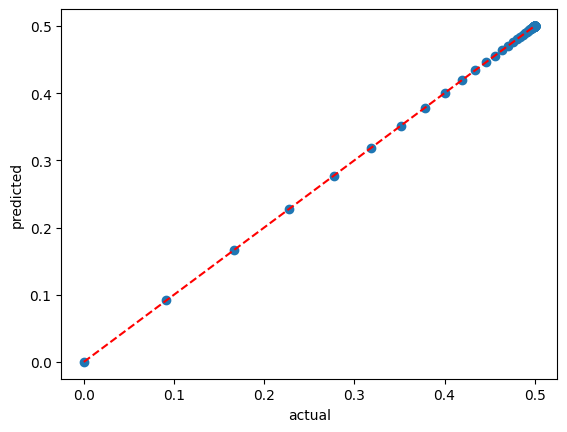

In [30]:
rr = te.loada(SEQUENTIAL_MODEL)
data = rr.simulate(0, 10, 100)
times = data["time"]
_, yt = control.step_response(G_tf, T=times)
plt.scatter(data["[S2]"], yt)
plt.plot([0, 0.5], [0, 0.5], color="red", linestyle="--")
plt.xlabel("actual")
plt.ylabel("predicted")

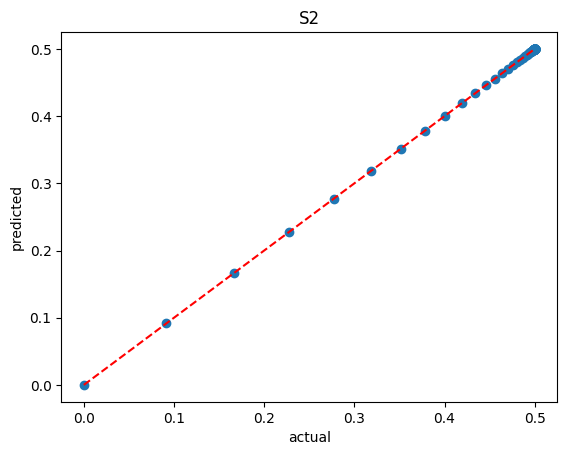

In [33]:
# We will reuse this approach, and so it's useful to have as a function
evaluateTransferFunction(SEQUENTIAL_MODEL, G_tf)

## 6: Analyze

All points line on the line of unit slope.

# Model 2: A more elaborate network

Consider the following model:
\begin{eqnarray}
S_1 & \xrightarrow{k_1 S_1} & S_2 \\
S_2 & \xrightarrow{k_2 S_2} & 3 S_2 + S_3 \\
S_3 & \xrightarrow{k_3 S_3} & \emptyset
\end{eqnarray}

Find the transfer function $G(s) = \frac{S_3 (s)}{S_1 (s)}$.

## 1. System equations

\begin{eqnarray}
\dot{S}_2 & = & k_1 S_1 + 2 k_2  S_2 \\
\dot{S}_3 & = & k_2 S_2 - k_3 S_3
\end{eqnarray}

## 2. LT of system equations

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) + 2 k_2  S_2 (s) \\
s S_3 (s) & = & k_2 S_2 (s) - k_3 S_3 (s)
\end{eqnarray}

## 3. Solve for the LT

Solve backwards from $X_3 (s)$

\begin{eqnarray}
S_3(s) & = &  \frac{k_2 S_2(s)}{s + k_3} \\
S_2(s) & = &  \frac{k_1 S_1(s)}{s - 2 k_2} \\
\end{eqnarray}

Substituting
$$S_3(s) = \frac{k_2}{s + k_3} \cdot \frac{k_1 S_1(s)}{s - 2k_2}$$

Therefore:

$$S_3(s) = \frac{k_1 k_2}{(s + k_3)(s - 2k_2)} S_1(s)$$

The transfer function from $S_1(s)$ to $S_3(s)$ is:

$$G (s)  =  \frac{S_3(s)}{S_1(s)} = \frac{k_1 k_2}{(s + k_3)(s - 2k_2)}$$

## 4. Interpret $G(s)$

* What are the poles?
* Is this a stable system? If so, for what values of kinetic constants?
* What is the DC gain?

## 5. Predict step response from TF

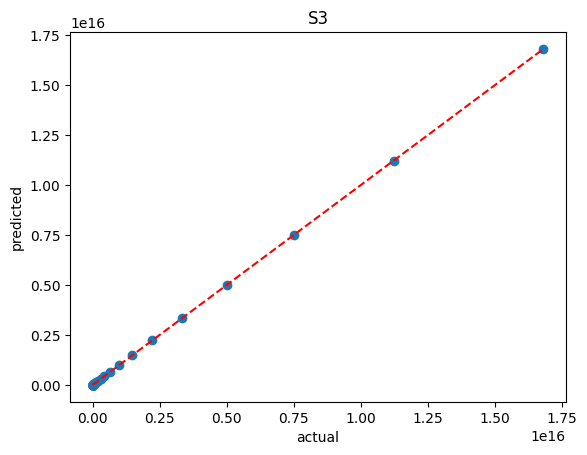

In [42]:
k1=1; k2=2; k3=3;
model = f"""
$S1 -> S2; k1*S1
S2 -> 3 S2 + S3; k2*S2
S3 -> ; k3*S3

S1 = 1
S2 = 0
S3 = 0
k1 = {k1}
k2 = {k2}
k3 = {k3}
"""
# Construct the transfer function for G(s) at k1=1
G_tf = control.TransferFunction([k2*k1], [1, k3 - 2*k2, -2*k2*k3])
#
evaluateTransferFunction(model, G_tf)

In [43]:
G_tf.dcgain(), G_tf.poles()

(-0.16666666666666666, array([ 4.+0.j, -3.+0.j]))

## 6. Analyze

The actual results match the predicted results.

The DC gain is meaningless since the system is not BIBO stable.

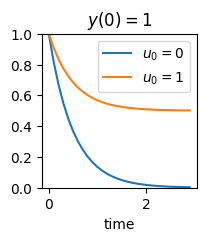

In [82]:
t = np.arange(0, 3, 0.1)
a = -2
y0 = 1
u0 = 1
_, ax = plt.subplots(1, figsize=(2, 2))
ax.plot(t, np.e**(a*t)*y0)
ax.plot(t, np.e**(a*t)*y0 + u0/a*(np.e**(a*t) - 1))
ax.set_title(r'$y(0) = $' + f"{y0}")
ax.set_xlabel("time")
ax.set_ylim([0, 1])
ax.legend([r'$u_0=0$', r'$u_0=1$'])